In [ ]:
from pandas import read_csv
from datetime import datetime
from google.colab import files
import io
import pandas as pd
from pandas import read_csv
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


In [ ]:
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
 
uploaded = files.upload()

Saving raw.csv to raw.csv


In [ ]:
dataset = read_csv(io.BytesIO(uploaded['raw.csv']), parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


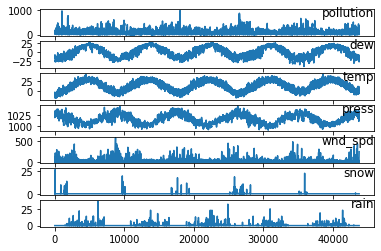

In [ ]:
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset

values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var7(t-1)  var8(t-1)   var1(t)
1   0.129779   0.352941   0.245902  ...   0.000000        0.0  0.148893
2   0.148893   0.367647   0.245902  ...   0.000000        0.0  0.159960
3   0.159960   0.426471   0.229508  ...   0.000000        0.0  0.182093
4   0.182093   0.485294   0.229508  ...   0.037037        0.0  0.138833
5   0.138833   0.485294   0.229508  ...   0.074074        0.0  0.109658

[5 rows x 9 columns]


In [ ]:
# import numpy as np
# mean = np.mean(reframed['var1(t-1)'])
# reframed.loc[reframed['var1(t)'] > mean , 'var1(t)'] = 1
# reframed.loc[reframed['var1(t)'] < mean , 'var1(t)'] = 0

# reframed

In [ ]:
# split into train and test sets
import numpy as np
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_b_y = np.array([1 if j > 0.05 else 0 for j in train_y])
test_b_y = np.array([1 if j > 0.05 else 0 for j in test_y])

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


Epoch 1/50
122/122 - 2s - loss: 0.6853 - accuracy: 0.6047 - val_loss: 0.6731 - val_accuracy: 0.5923
Epoch 2/50
122/122 - 1s - loss: 0.6569 - accuracy: 0.6070 - val_loss: 0.6500 - val_accuracy: 0.5923
Epoch 3/50
122/122 - 1s - loss: 0.6308 - accuracy: 0.6086 - val_loss: 0.6265 - val_accuracy: 0.5926
Epoch 4/50
122/122 - 1s - loss: 0.5994 - accuracy: 0.6555 - val_loss: 0.5918 - val_accuracy: 0.7039
Epoch 5/50
122/122 - 1s - loss: 0.5577 - accuracy: 0.7644 - val_loss: 0.5479 - val_accuracy: 0.7811
Epoch 6/50
122/122 - 1s - loss: 0.5071 - accuracy: 0.8191 - val_loss: 0.5036 - val_accuracy: 0.8094
Epoch 7/50
122/122 - 1s - loss: 0.4499 - accuracy: 0.8653 - val_loss: 0.4763 - val_accuracy: 0.8118
Epoch 8/50
122/122 - 1s - loss: 0.3933 - accuracy: 0.9003 - val_loss: 0.4496 - val_accuracy: 0.8195
Epoch 9/50
122/122 - 1s - loss: 0.3464 - accuracy: 0.9166 - val_loss: 0.4122 - val_accuracy: 0.8392
Epoch 10/50
122/122 - 1s - loss: 0.3066 - accuracy: 0.9241 - val_loss: 0.3727 - val_accuracy: 0.8582

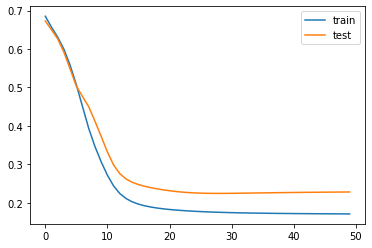

In [ ]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(LSTM(4,return_sequences=True))
model.add(LSTM(2,return_sequences=False))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(train_X, train_b_y, epochs=50, batch_size=72, validation_data=(test_X, test_b_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
model = Sequential()
model.add(LSTM(8,input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(LSTM(4,return_sequences=True))
model.add(LSTM(2,return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_X, train_b_y, epochs=750, batch_size=100,verbose=0,shuffle=True)

y_pred = model.predict_classes(test_X)
print(classification_report(test_b_y, y_pred))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


NameError: ignored

In [ ]:
# make a prediction
print(test_X.shape)
yhat = model.predict(test_X)
yhat

(35039, 1, 8)


array([[0.1016655 ],
       [0.06644031],
       [0.02969411],
       ...,
       [0.01602232],
       [0.01598912],
       [0.01553574]], dtype=float32)

In [ ]:

test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X_reshaped[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X_reshaped[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 662.968
